# Correct Signals for Direct Component
## Abstract
- File 'Direct_.8' was measured 2-2.5 m above ground level with distance .8 m
- This is the direct component by some margin C_dir is ommitted here

## Doing
- Load averaged impulse
- Sync all
- Window 'Direct_.8' and substract it from the rest

## Files
From: TARGET_DIR/IMP_{Measurement Position}.wav 

In [2]:
# 1. Import, Base Settings (System) and Base Settings (User)
from reflection_definitions import *

%matplotlib notebook
plt.rcParams['axes.grid'] = True    # Set grid in plots on per default
VERBOSE = False
F_up = 500e3


############################################################
########## User Interaction Starts Here       ##############
########## Please specify where the Files are ##############
############################################################

TARGET_DIR = 'C:/Users/gmeinwieserch/Desktop/04  St-Martha Kirche/211007_Martha/Wall_Refl/'
NAME = 'IMP_%s.wav'

NR = {'Wand_0_0': ['Wall - LR = 0 m, H = 0 m, NeutrH = 1.6 m'],
      'Wand_+_0': ['Wall - LR = +.4 m, H = 0 m, NeutrH = 1.6 m'],
      'Wand_-_0': ['Wall - LR = -.4 m, H = 0 m, NeutrH = 1.6 m'],
      'Wand_0_+': ['Wall - LR = 0 m, H = +.4 m, NeutrH = 1.6 m'],
      'Wand_0_-': ['Wall - LR = 0 m, H = -.4 m, NeutrH = 1.6 m'],
      'Boden_1.5': ['Floor - A = 1.5 m, H = .93 m'],
      'Boden_.2': ['Floor - A = .2 m, H = .93 m'],
      'Direct_.8': ['Direct - A  =  .8 m, H = 2 m']}

################################################################
######### Please specify the exitation pars        #############
################################################################
par_sweep = [63, 10, 5e3]   # parameter of sweep [fstart, T, fend]

In [3]:
for position in NR.keys():
    # Loop will load wav signals to a list wich is the value of the NR dict
    # = Complete Reflection
    del NR[position][1:]  # Reset List after title field
    NR[position].append(Signal(path=TARGET_DIR, name=NAME %
                        (position)))  # Append signal obj

direct = NR.pop('Direct_.8')

# Distance Correction: Norm everything to a 1 m distance
# direct: .8
# Reflection: .25 * 2 + 1
# p_2/p_1 = (d_1/d_2)^2

d_fak_dir = (1/.8)**2
d_fak_ref = (1/1.5)**2

for position in NR.keys():
    NR[position][-1].y *= d_fak_ref
direct[-1].y *= d_fak_dir

In [4]:
for position in NR.keys():
    del NR[position][2:]  # Reset List after input signal field

    # Complete Reflection - external Direct signal = isolated Reflection
    sig = np.copy(NR[position][1].resample(F_up).y)    # Complete
    cor = np.copy(direct[1].resample(F_up).y)  # External Direct
    fak = max(sig)/max(cor)
    #                         Complete - External Direct
    NR[position].append(Signal(y=sig - fak*cor, dt=1 /
                        F_up).resample(1/direct[1].dt))

In [5]:
for position in NR.keys():
    del NR[position][3:]  # Reset List after input signal field

    # Calculate Transfer fkt
    tf = TransferFunction(
        incoming_sig=direct[1], reflected_sig=NR[position][2])
    tf_oct = tf.get_octave_band(fact=1/3)
    NR[position].append(tf)
    NR[position].append(tf_oct)

<IPython.core.display.Javascript object>


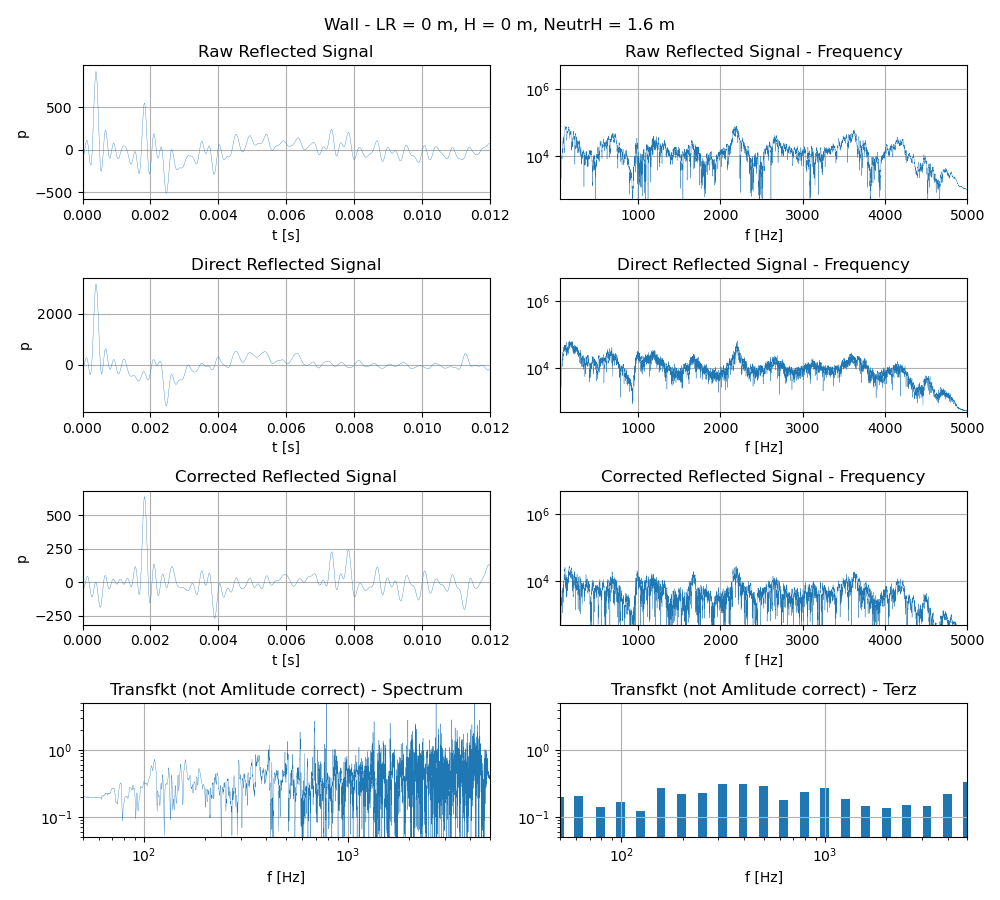

<IPython.core.display.Javascript object>


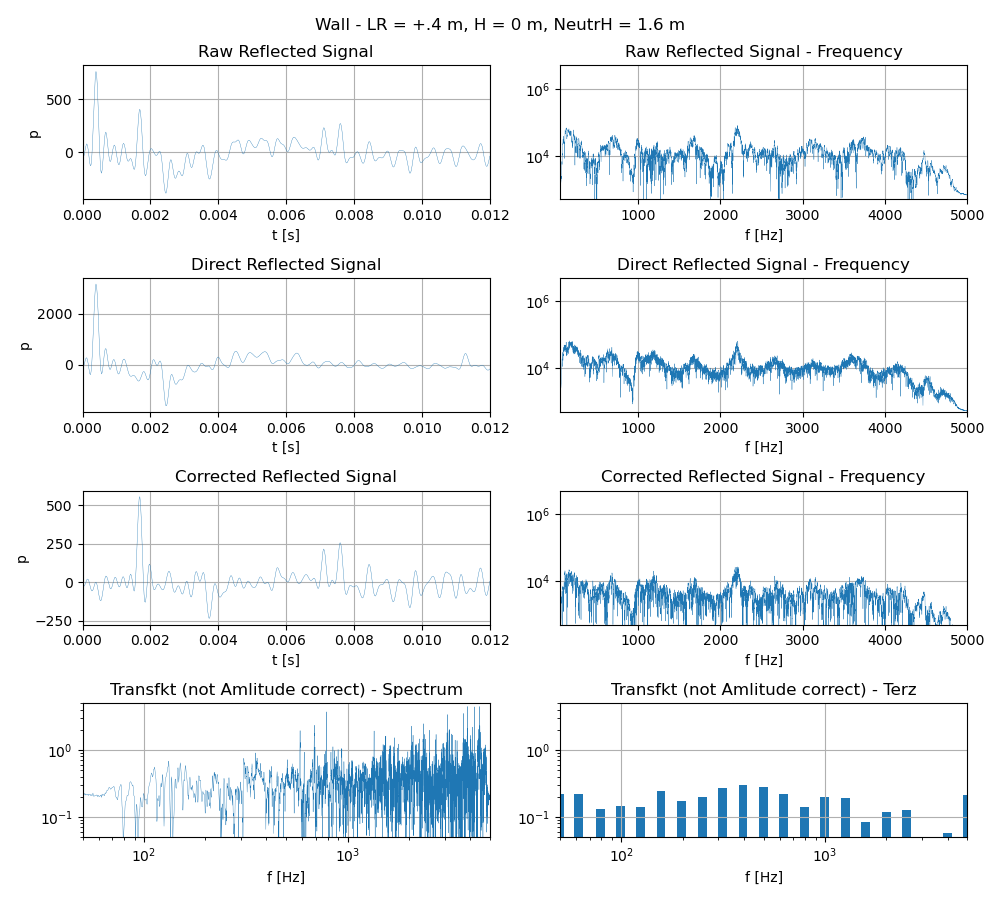

<IPython.core.display.Javascript object>


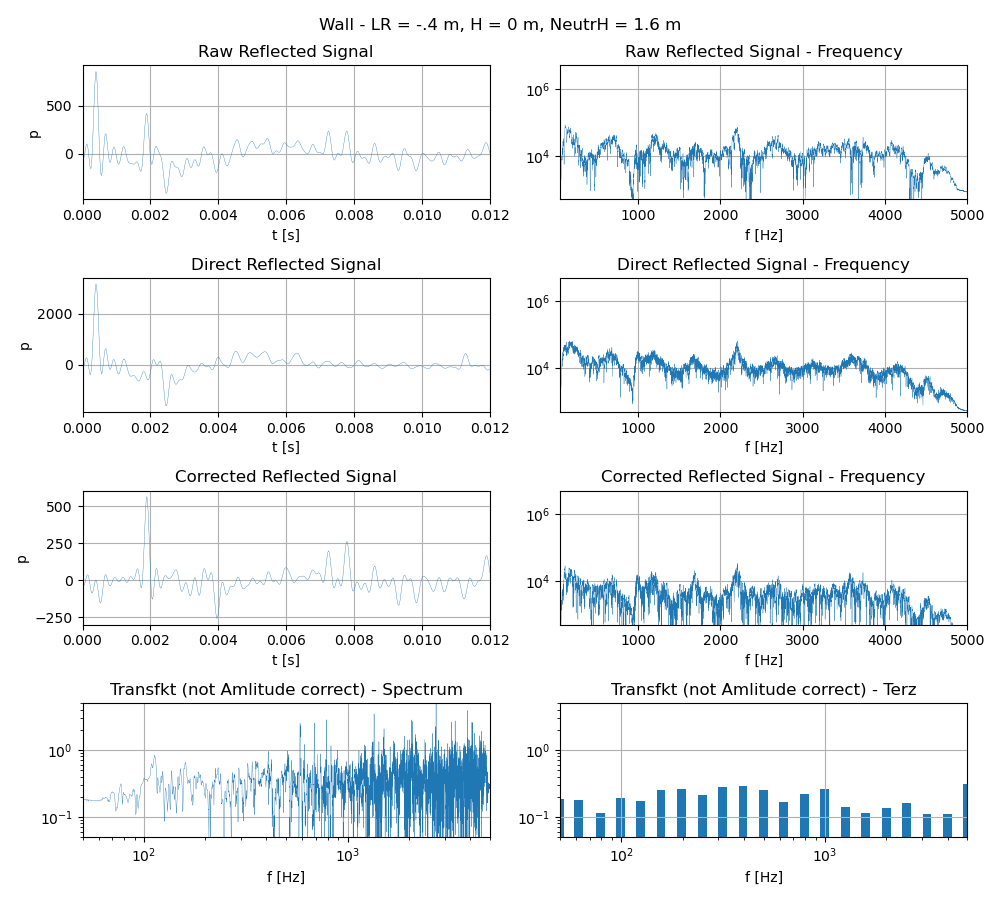

<IPython.core.display.Javascript object>


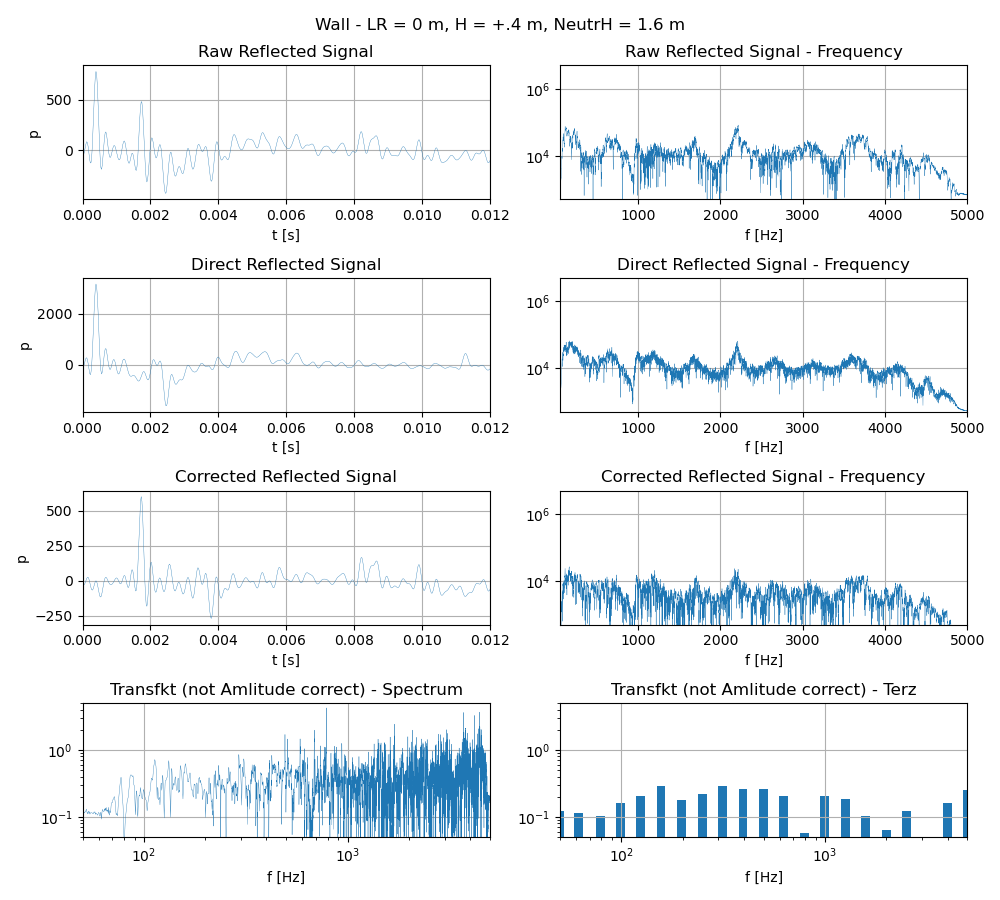

<IPython.core.display.Javascript object>


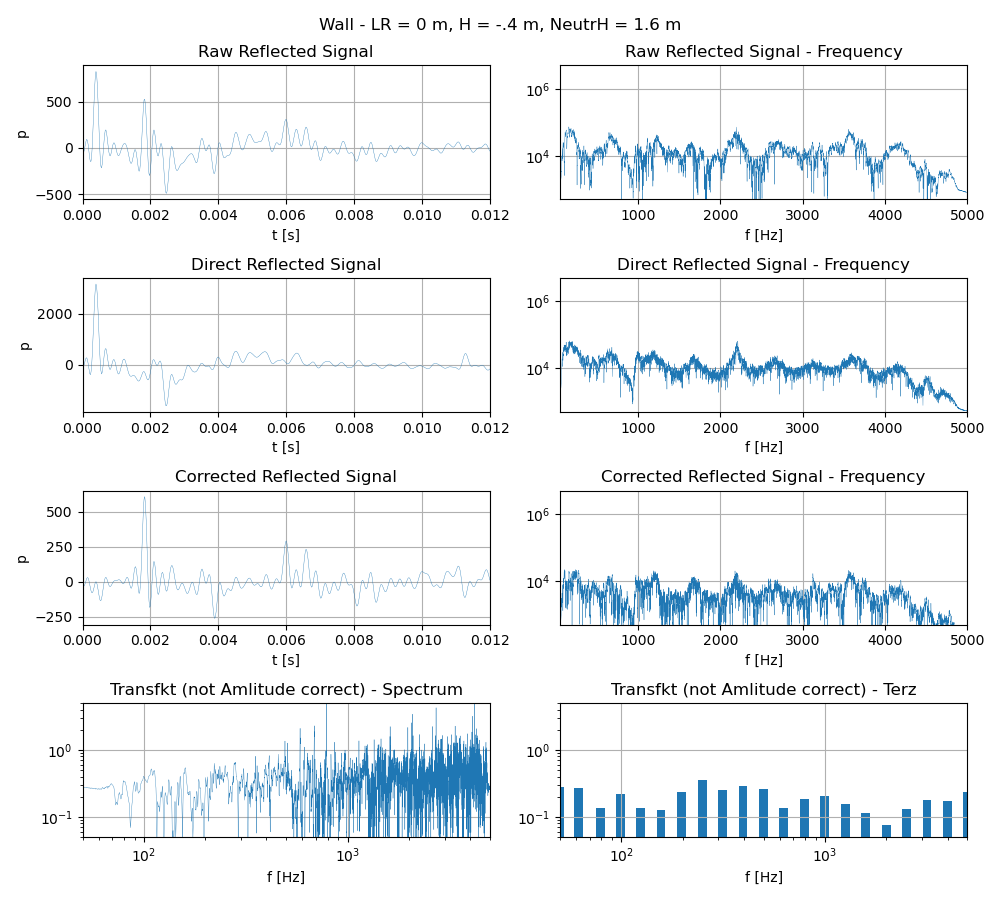

<IPython.core.display.Javascript object>


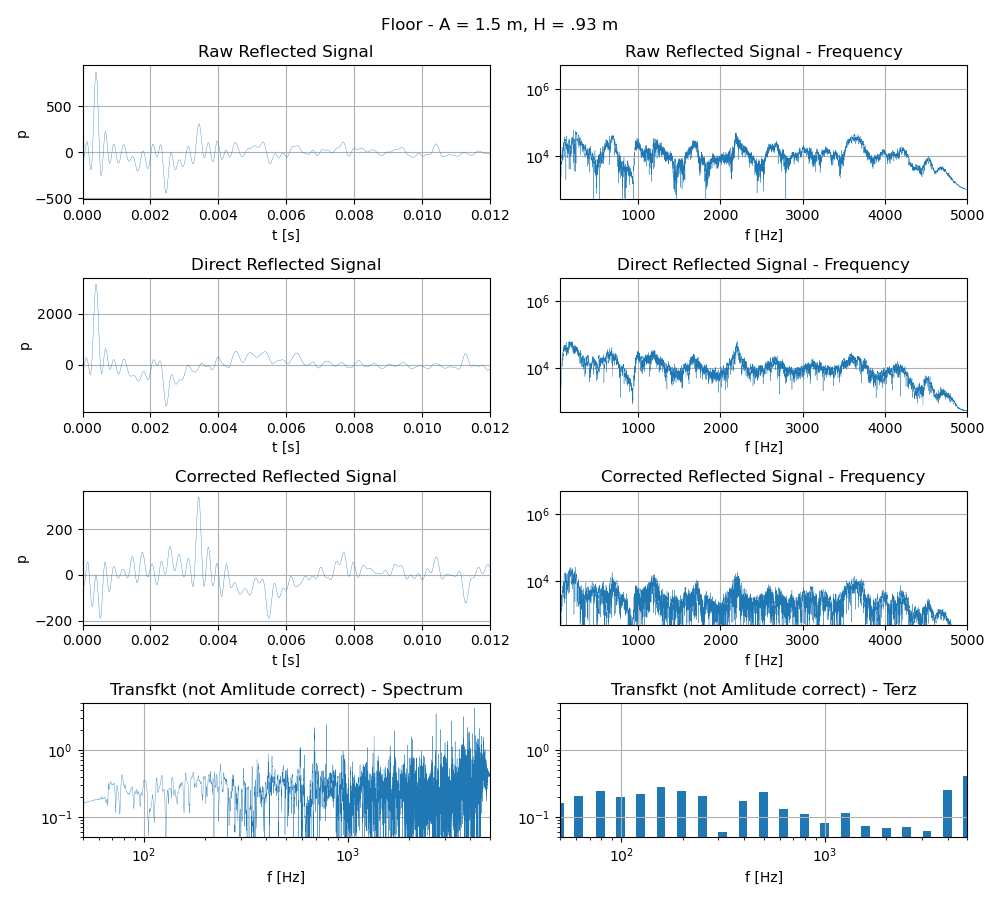

<IPython.core.display.Javascript object>


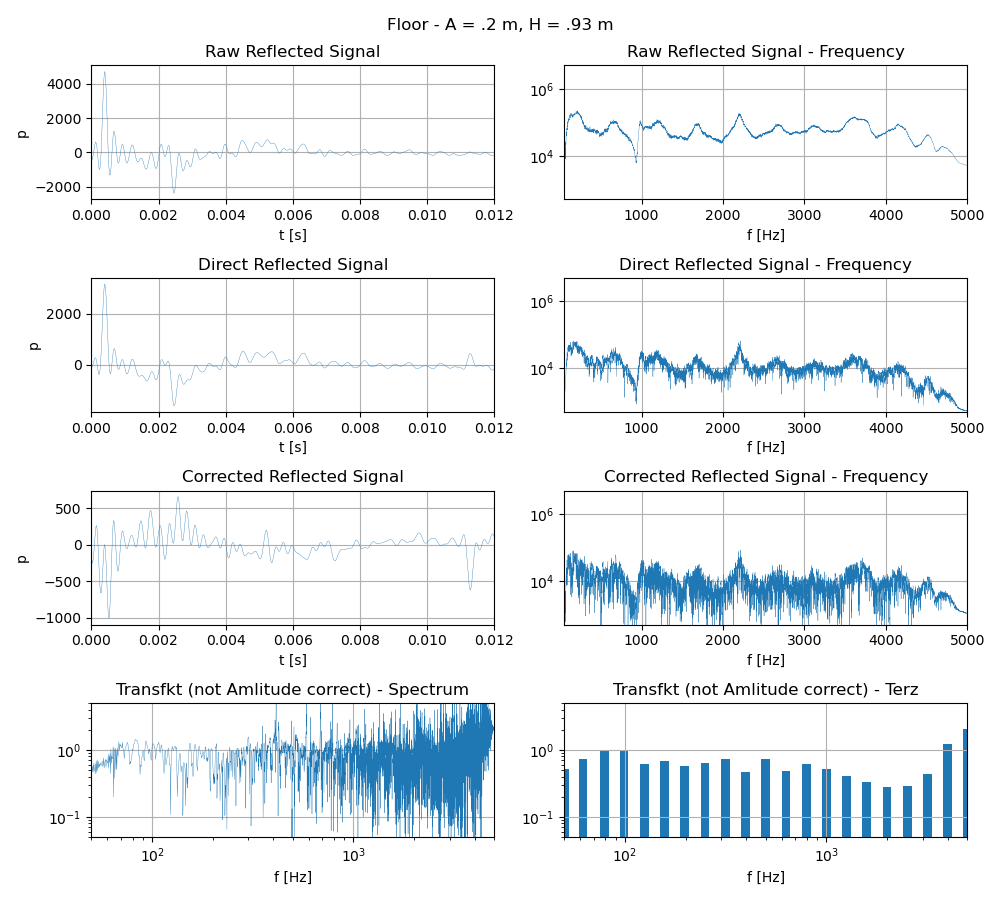

In [6]:
def plot_t_f(ax, sig):
    ax[0].plot(sig.axis_arrays['t'],
               sig.y,
               linewidth=.25)

    ax[1].plot(sig.axis_arrays['xf'],
               np.absolute(sig.y_f[:int(sig.n_tot/2)]),
               linewidth=.25)
    ax[0].set_xlim(0, .012)
    ax[0].set_xlabel('t [s]')
    ax[0].set_ylabel('p')

    ax[1].set_xlim(50, 5e3)
    ax[1].set_xlabel('f [Hz]')
    ax[1].set_yscale('log')
    ax[1].set_ylim(5e2, 5e6)


for position in NR.keys():
    if True:
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 2, figsize=(10, 9))
        plot_t_f(ax1, NR[position][1])
        ax1[0].set_title('Raw Reflected Signal')
        ax1[1].set_title('Raw Reflected Signal - Frequency')

        plot_t_f(ax2, direct[1])
        ax2[0].set_title('Direct Reflected Signal')
        ax2[1].set_title('Direct Reflected Signal - Frequency')

        plot_t_f(ax3, NR[position][2])
        ax3[0].set_title('Corrected Reflected Signal')
        ax3[1].set_title('Corrected Reflected Signal - Frequency')

        # Plot Transfer Fkt
        tf = NR[position][3]
        ax4[0].plot(tf.xf,
                    np.absolute(tf.hf[:int(tf.n_tot/2)]),
                    linewidth=.25)

        tf = NR[position][4]
        ax4[1].bar(tf.xf,
                   np.absolute(tf.hf),
                   .1*tf.xf)
        for ax in ax4:
            ax.set_xlim(50, 5e3)
            ax.set_xlabel('f [Hz]')
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.set_ylim(.05, 5)

        ax4[0].set_title('Transfkt (not Amlitude correct) - Spectrum')
        ax4[1].set_title('Transfkt (not Amlitude correct) - Terz')

        fig.suptitle(NR[position][0])
        fig.tight_layout()
    else:
        tf = NR[position][4]
        fig, ax = plt.subplots(1, figsize=(10, 6))

        ax.bar(tf.xf,
               np.absolute(tf.hf),
               .1*tf.xf)

        ax.set_xlim(50, 5e3)
        ax.set_xlabel('f [Hz]')
        ax.set_xscale('log')
        ax.set_yscale('log')
        #ax.set_ylim(.05, 1)

        ax.set_title('Transfkt (Magnitude roughly corrected) - Terz')

        fig.suptitle(NR[position][0])
        fig.tight_layout()

In [7]:
for position in NR.keys():
    print(position + ': ')
    freq = NR[position][4].xf
    pin = NR[position][4].hf
    print('\tF [Hz]\tFaktor []')
    for i, fi in enumerate(freq):
        print('\t' + str(fi) + '\t' + str(pin[i]))

Wand_0_0: 
	F [Hz]	Faktor []
	16	0.33774047512372096
	20	0.3078189721609871
	25	0.2763604851441719
	31	0.24809361438791266
	39	0.21887776782562804
	50	0.19928843016255082
	62	0.20435919258120466
	79	0.13964310865187993
	99	0.16869011306240464
	125	0.12172530435802593
	157	0.2732345451392899
	198	0.21750063842801123
	250	0.23095488409462883
	315	0.30629189405610635
	397	0.31068239377089857
	500	0.28573184127663304
	630	0.18138327535077228
	794	0.23299337070230375
	1000	0.27395488010136515
	1260	0.18231055370034926
	1587	0.14649670125704478
	2000	0.13652327887136145
	2520	0.1524953342978311
	3175	0.14802970106599772
	4000	0.21977564928493723
	5040	0.3306594684694354
	6350	0.3971458511895681
	8000	0.42137306554593007
	10079	0.4380889606713359
	12699	0.4490490338947897
	16000	0.456108897127762
Wand_+_0: 
	F [Hz]	Faktor []
	16	0.47222097327989915
	20	0.4231985546011182
	25	0.36746331470574567
	31	0.31698324148302537
	39	0.2680365702416867
	50	0.22311589603576581
	62	0.21829979442950895
	79	

In [ ]:
NR